In [227]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device + " is available")
 
learning_rate = 0.01
batch = 4
epochs = 20

cuda is available


In [228]:
import cv2
import numpy as np
import os
from PIL import Image
from collections import Counter

test = Image.open('./train_set/target/1.png')
data_dir = os.listdir('./train_set/data')
target_dir = os.listdir('./train_set/target')
train_set = [Image.open('./train_set/data/'+dir).resize((512,512)) for dir in data_dir]
target_set = [Image.open('./train_set/target/'+dir).resize((512,512)) for dir in target_dir]

In [229]:
x = train_set
y = target_set

In [230]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
x_train, x_valid, y_train,  y_valid = train_test_split(x_train, y_train, test_size=0.25, shuffle=True )

In [231]:
from typing import Any


class Normalization(object):
  def __init__(self, mean=0.5 , std=0.5):
    self.mean = mean
    self.std = std
  
  def __call__(self, data):

    data =(data - self.mean) / self.std

    return data

class image2np(object):
  def __init__(self, label):
    self.label = label

  def __call__(self, img):
    img = np.array(img, dtype=np.float32)
    if img.ndim == 2:
      img = img[:, :, np.newaxis]
    if self.label:
      img = np.where(img == 0, 1, 255)
    return img/255

In [232]:
import albumentations as a
def image_printer(flag,x_res,y_res):
    if flag:
            plt.subplot(1,2,1)
            plt.imshow(transforms.ToPILImage()(x_res[-1]))
            plt.subplot(1,2,2)
            plt.imshow(transforms.ToPILImage()(y_res[-1]))
            plt.show()

def image_preprocess(img_arr, target_arr, train = True):
    flag = 1
    blur = a.OneOf([
                a.MotionBlur(p=1),
                a.OpticalDistortion(p=1)           
    ], p=1)
    x_res = []
    y_res = []
    x_compose = [
        Normalization(mean= 0.5, std =0.5),
        transforms.ToTensor()
    ]
    y_compose = [
        transforms.ToTensor()
    ]
    
    tf1 = transforms.Compose(x_compose)
    tf2 = transforms.Compose(y_compose)

    if train:
        for new_img,target in zip(image2np(label=False)(img_arr),image2np(label=True)(target_arr)):
            res = a.VerticalFlip(p=1)(image = new_img, mask = target)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(tf2(res['mask']))
            image_printer(flag, x_res, y_res)

            res = a.HorizontalFlip(p=1)(image = new_img, mask = target)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(tf2(res['mask']))
            image_printer(flag, x_res, y_res)

            res = a.Affine(p=1)(image = new_img, mask = target)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(tf2(res['mask']))
            image_printer(flag, x_res, y_res)

            res = a.RandomGridShuffle(grid=(5,5), p=1)(image = new_img, mask = target)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(tf2(res['mask']))
            image_printer(flag, x_res, y_res)

            res = a.RandomGridShuffle(grid=(7,7), p=1)(image = new_img, mask = target)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(tf2(res['mask']))
            image_printer(flag, x_res, y_res)

            res = a.RandomGridShuffle(grid=(3,3), p=1)(image = new_img, mask = target)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(tf2(res['mask']))
            image_printer(flag, x_res, y_res)

            res = a.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)(image = new_img, mask = target)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(tf2(res['mask']))
            image_printer(flag, x_res, y_res)

            x_res.append(tf1(new_img))
            y_res.append(tf2(target))
            image_printer(flag, x_res, y_res)
            flag = 0
    else:
        for new_img,target in zip(image2np(label=False)(img_arr),image2np(label=True)(target_arr)):            
            x_res.append(tf1(new_img))
            y_res.append(tf2(target))
    
    return x_res, y_res

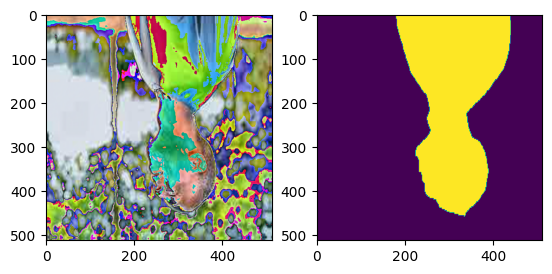

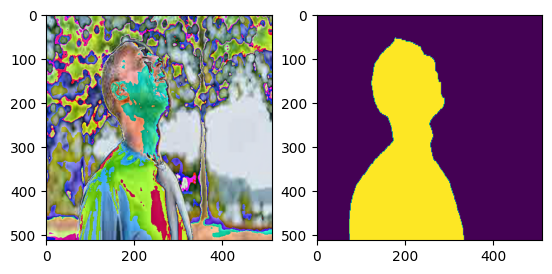

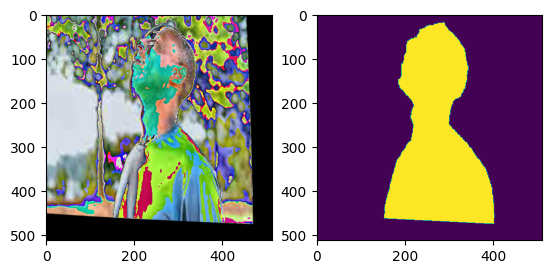

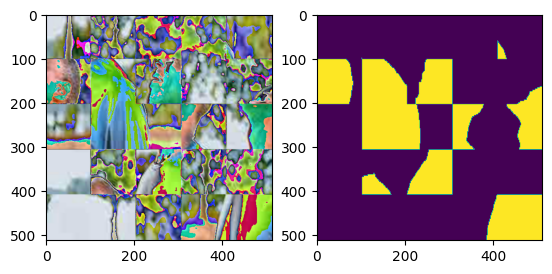

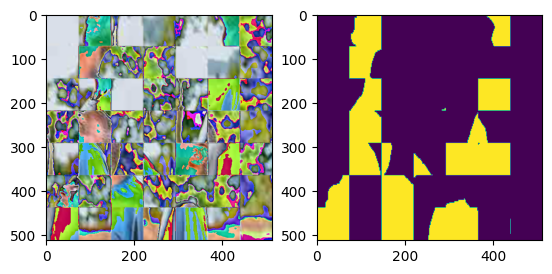

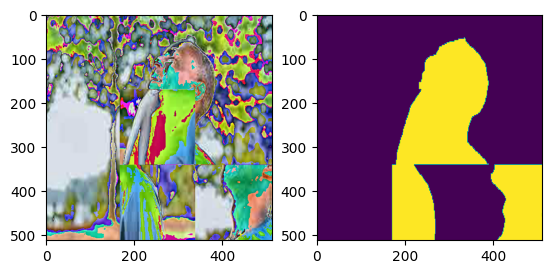

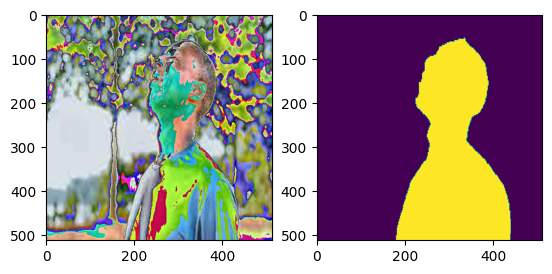

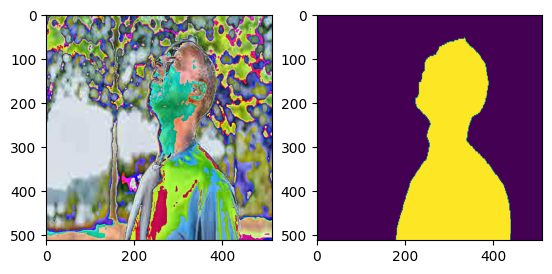

In [233]:
# 이미지 전처리 적용
x_train, y_train = image_preprocess(x_train, y_train)
x_valid, y_valid = image_preprocess(x_valid, y_valid, train=False)
x_test, y_test = image_preprocess(x_test, y_test, train=False)

In [234]:
from torch.utils.data import TensorDataset, DataLoader

traindata = TensorDataset(torch.stack(x_train),torch.stack(y_train))
validdata = TensorDataset(torch.stack(x_valid),torch.stack(y_valid))
testdata = TensorDataset(torch.stack(x_test),torch.stack(y_test))

trainLoader = DataLoader(
    traindata,
    batch_size=batch,
    shuffle = True
)
validLoader = DataLoader(
    validdata,
    batch_size=batch,
    shuffle = True
)
testLoader = DataLoader(
    testdata,
    batch_size=1,
    shuffle = True
)

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
[-1.         -0.9999157  -0.99987745 ...  0.99969363  0.9997549
  1.        ]


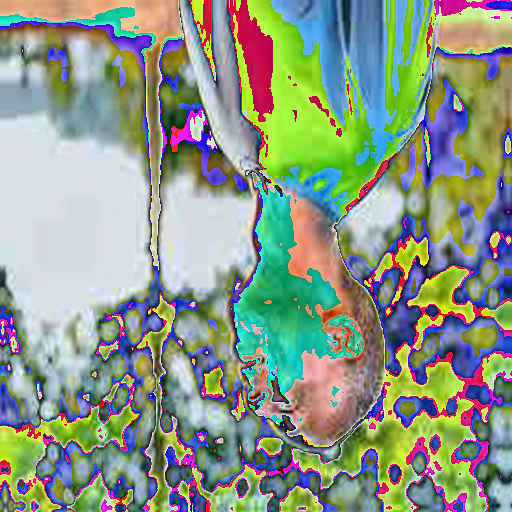

In [235]:
#Loader test
test = iter(traindata)
a,b = next(test)
print(a.shape,b.shape)
print(np.unique(a))
transforms.ToPILImage()(a)

In [236]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        self.enc1_1 = CBR2d(in_channels=3, out_channels =64, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc1_2 = CBR2d(in_channels=64, out_channels =64, kernel_size =3, stride=1, padding =1, bias =True)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels =128, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc2_2 = CBR2d(in_channels=128, out_channels =128, kernel_size =3, stride=1, padding =1, bias =True)
        
        self.pool2 = nn.MaxPool2d(kernel_size =2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc3_2 = CBR2d(in_channels=256, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)

        self.pool3 = nn.MaxPool2d(kernel_size =2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc4_2 = CBR2d(in_channels=512, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)

        self.pool4 = nn.MaxPool2d(kernel_size =2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels =1024, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc5_2 = CBR2d(in_channels=1024, out_channels =1024, kernel_size =3, stride=1, padding =1, bias =True)

        self.dec5_1 = CBR2d(in_channels=1024, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)

        self.unpool4 = nn.ConvTranspose2d(in_channels =512, out_channels = 512, kernel_size = 2, stride = 2, padding = 0, bias = True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)
        self.dec4_1 = CBR2d(in_channels=512, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):

        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)

        dec5_1 = self.dec5_1(enc5_2)
        
        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2),dim =1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2),dim =1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2),dim =1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2),dim =1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [237]:
fn_class = lambda x: 1.0 * (x > 0.5)
fn_class2 = lambda x: x + 1.0 * (x == 0)
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)

In [238]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

rgb_model = Unet().to(device) 
rgb_model.apply(initialize_weights) 
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(rgb_model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=3, eps = 1e-05)
train_avg_cost = []
train_acc = []
valid_avg_cost = [] 
valid_acc = []
lr = []

for epoch in range(epochs): 
    rgb_model.train()
    avg_cost = 0
    correct = 0
    total = 0
    print(optimizer.param_groups[0]['lr'])
    lr.append(optimizer.param_groups[0]['lr'])
    for data, target in trainLoader:
        # print(data.shape)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() 
        hypothesis = rgb_model(data)
        # print(hypothesis)
        cost = criterion(hypothesis, target)
        out = fn_class(hypothesis)
        total += len(target)
        correct += (fn_class2(out*255)==target*255).sum().item()
        cost.backward() 
        optimizer.step()
        avg_cost += cost / len(trainLoader)
        
    train_avg_cost.append(float(avg_cost))
    train_acc.append(100.*correct/total/262144)
    avg_cost = 0
    correct = 0
    total = 0

    rgb_model.eval() 
    with torch.no_grad(): 
        for data, target in validLoader:
            data = data.to(device)
            target = target.to(device)
            hypothesis = rgb_model(data) 
            cost = criterion(hypothesis, target)
            out = fn_class(hypothesis)
            total += len(target)
            correct += (fn_class2(out*255)==target*255).sum().item()
            avg_cost += cost / len(trainLoader)
        valid_avg_cost.append(float(avg_cost))
        valid_acc.append(100.*correct/total/262144)
    scheduler.step(valid_avg_cost[-1])
    print('[Epoch: {:>4}] traincost = {:>.9} validcost = {:>.9}'.format(epoch + 1, train_avg_cost[-1],valid_avg_cost[-1]))
    # torch.save(rgb_model, f'./model{epoch}.pt')

if device == 'cuda':
    torch.cuda.empty_cache() # 캐시 쌓임에 다른 속도저하 방지차 GPU 메모리 초기화

0.01
[Epoch:    1] traincost = 0.458963917 validcost = 0.0213835671
0.01
[Epoch:    2] traincost = 0.38524743 validcost = 0.0183943201
0.01
[Epoch:    3] traincost = 0.345227683 validcost = 0.0216295379
0.01
[Epoch:    4] traincost = 0.330987847 validcost = 0.0194809012
0.01
[Epoch:    5] traincost = 0.321273757 validcost = 0.0187423676
0.01
[Epoch:    6] traincost = 0.308012737 validcost = 0.0156540845
0.01
[Epoch:    7] traincost = 0.297192306 validcost = 0.0146367737
0.01
[Epoch:    8] traincost = 0.291772663 validcost = 0.0138852046
0.01
[Epoch:    9] traincost = 0.279800974 validcost = 0.012584731
0.01
[Epoch:   10] traincost = 0.282082935 validcost = 0.0170963014
0.01
[Epoch:   11] traincost = 0.276107292 validcost = 0.0138810605
0.01
[Epoch:   12] traincost = 0.2610349 validcost = 0.0114079633
0.01
[Epoch:   13] traincost = 0.258945477 validcost = 0.0137070276
0.01
[Epoch:   14] traincost = 0.251527774 validcost = 0.0112212745
0.01
[Epoch:   15] traincost = 0.247021922 validcost

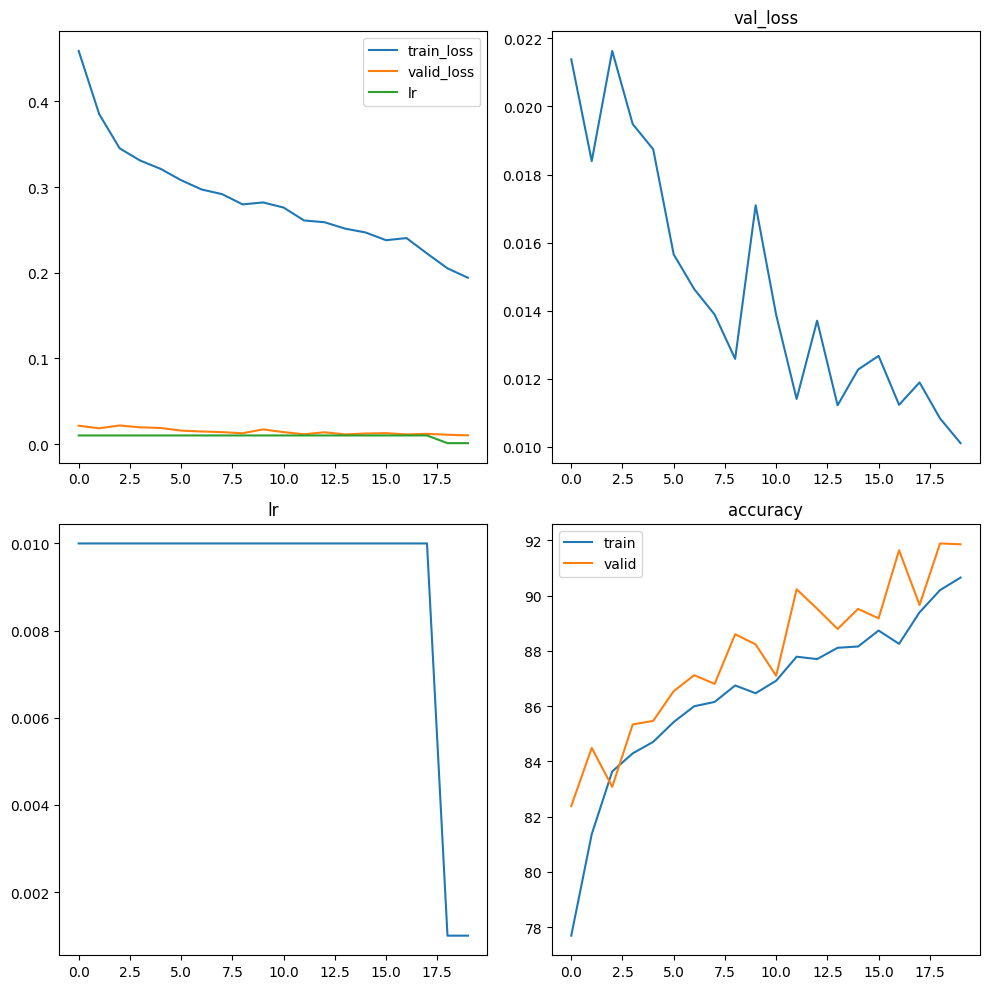

In [239]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(range(epochs), train_avg_cost)
plt.plot(range(epochs), valid_avg_cost)
plt.plot(range(epochs), lr)
plt.legend(['train_loss','valid_loss','lr'])

plt.subplot(2,2,2)
plt.plot(valid_avg_cost)
plt.title('val_loss')

plt.subplot(2,2,3)
plt.plot(lr)
plt.title('lr')

plt.subplot(2,2,4)
plt.title('accuracy')
plt.plot(range(epochs), train_acc)
plt.plot(range(epochs), valid_acc)
plt.legend(['train','valid'])
plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()

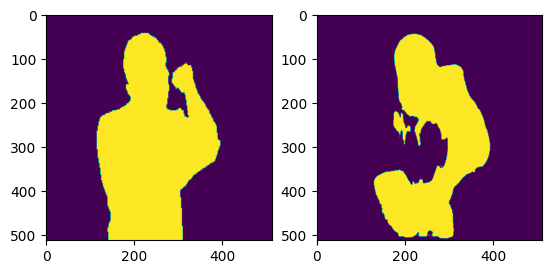

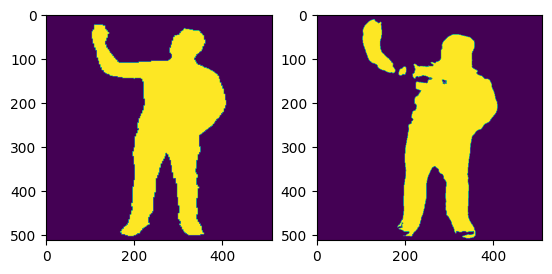

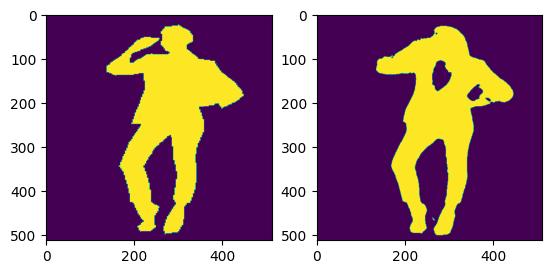

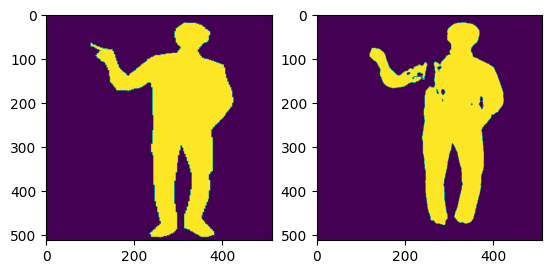

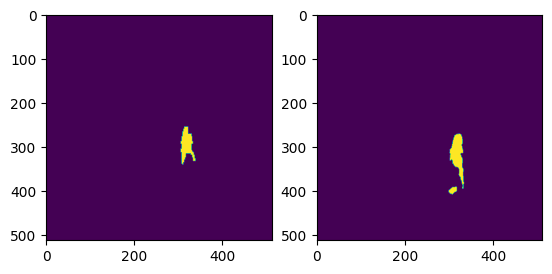

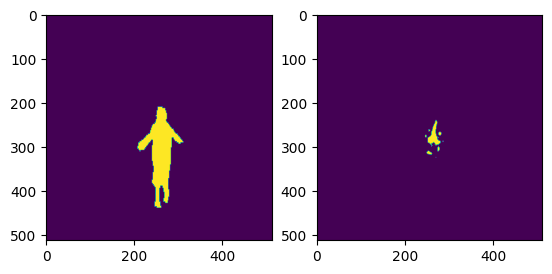

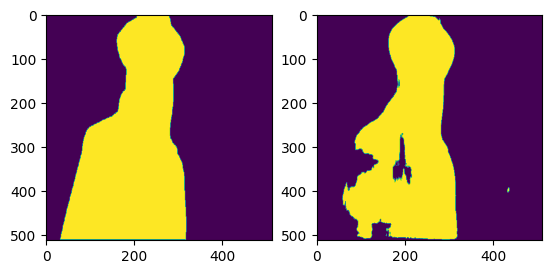

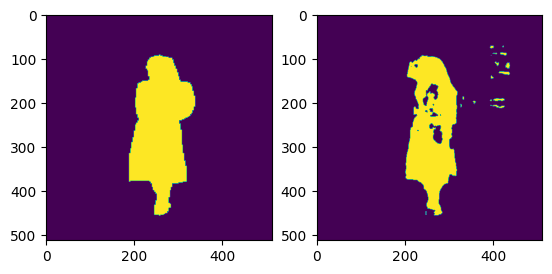

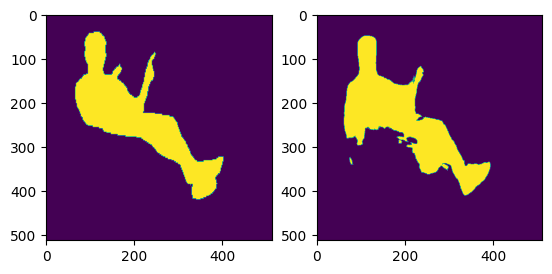

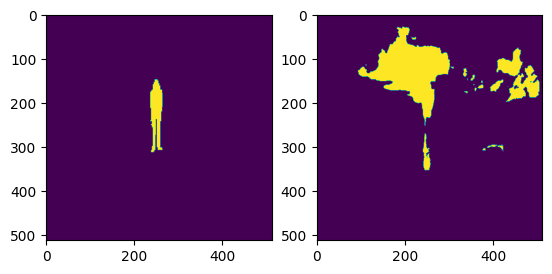

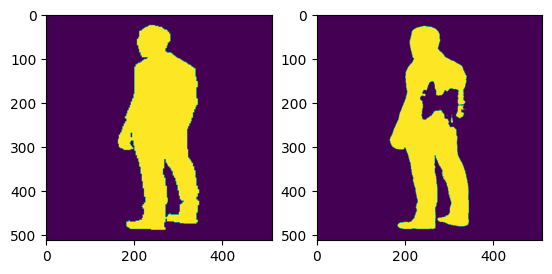

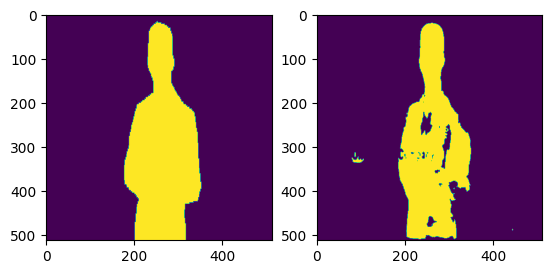

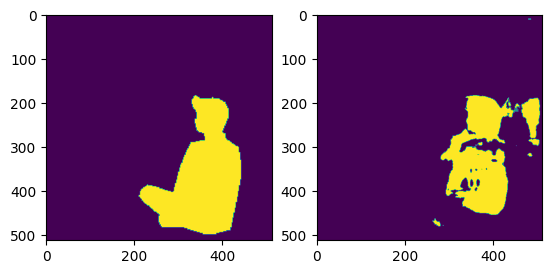

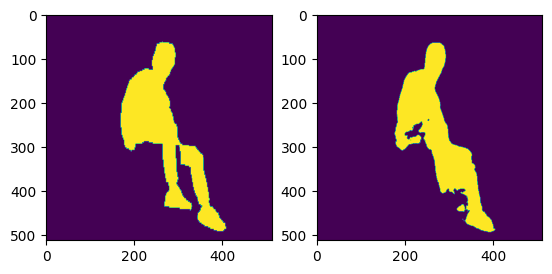

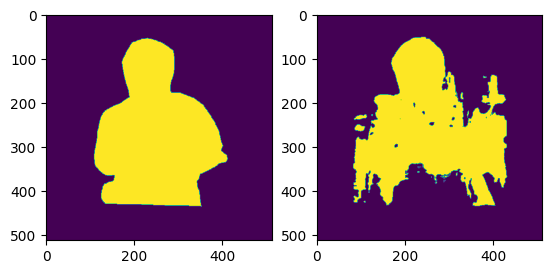

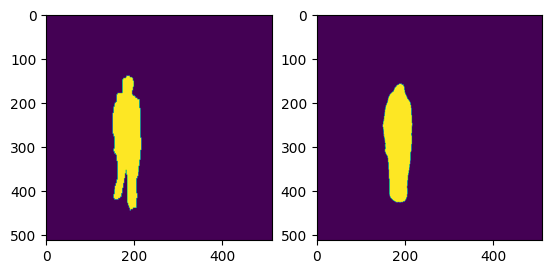

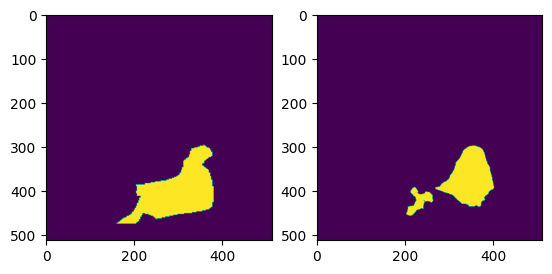

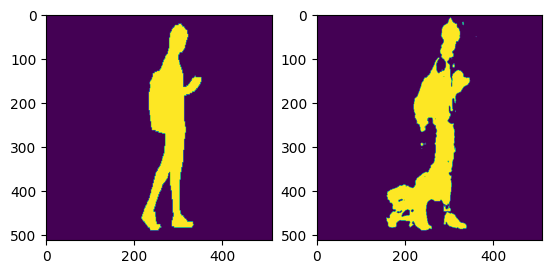

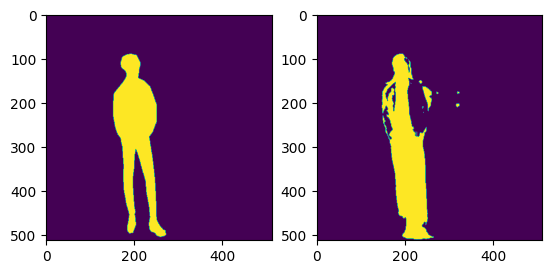

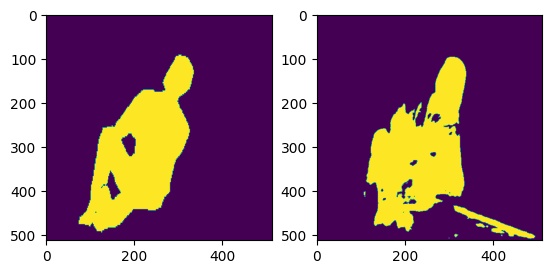

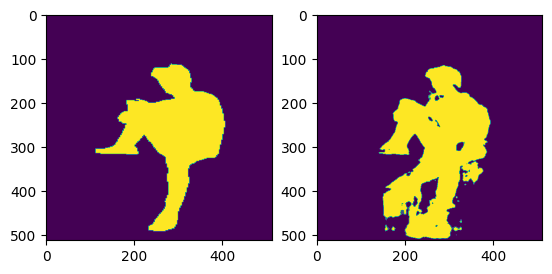

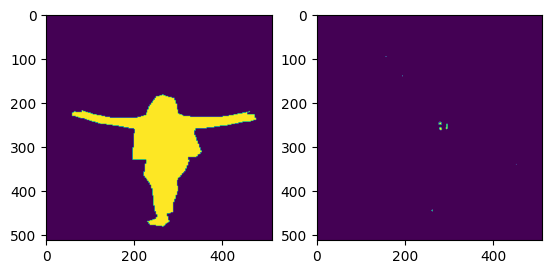

Test Accuracy:  94.3735122680664 %


In [240]:
# rgb_model = torch.load('./segmentation.pt')
rgb_model.eval() 
trues = []
preds = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data, target in testLoader:
        # print(data)
        data = data.float().to(device)
        target = target.to(device)
        out = fn_class(rgb_model(data))
        trues.append(fn_class2(out*255).cpu())
        preds.append((target.cpu())*255)
        correct += (fn_class2((out.cpu())*255)==(target.cpu())*255).sum().item()
        plt.subplot(1,2,1)
        plt.imshow(transforms.ToPILImage()(((target[0].cpu()))))
        PIL_out = fn_tonumpy(out)[0][:,:,0]
        plt.subplot(1,2,2)
        plt.imshow(Image.fromarray((PIL_out*255).astype(np.uint8)))
        plt.show()
        out = fn_tonumpy(out)
        total += len(target)
print('Test Accuracy: ', 100.*correct/total/262144, '%')

In [241]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
y_pred=np.array(preds).flatten()
y_true=np.array(trues).flatten()
mat = confusion_matrix(y_pred=np.array(preds).flatten(), y_true=np.array(trues).flatten())
print(mat)
tp, fp, fn, tn = mat[0,0], mat[0,1], mat[1,0], mat[1,1]
print(tp, fp, fn, tn)

print('recall_score : {:>.4}'.format(tp/(tp+fn)*100))
print('precision_score : {:>.4}'.format(tp/(tp+fp)*100))
print('F1_score : {:>.4}'.format(2*(tp/(tp+fn)*100)*(tp/(tp+fp)*100)/((tp/(tp+fn)*100)+(tp/(tp+fp)*100))))
print('acc : {:>.4}'.format((tp+tn)/(tp+fp+fn+tn)*100))

[[4736481  203030]
 [ 121459  706198]]
4736481 203030 121459 706198
recall_score : 97.5
precision_score : 95.89
F1_score : 96.69
acc : 94.37
